# Project Proposal


## Introduction
Rice is one of the most popular grain products in the world and it plays an important role in both nutrition and cultural and regional agriculture. There are many species of rice that are grown in different countries and different species can be distinguished by many characteristics such as physical properties, cooking features, taste, and others. These characteristics are usually used for quality criteria examination or determination of various types. However, it might be inefficient to proceed using some of these characteristics. Therefore, according to many studies, physical properties are found to be useful and less time-consuming.

In our project, we will concentrate on the prediction of different rice types based on information on the appearance of the rice and its accuracy. We will focus on two rice species in Turkey—Osmancik and Cammeo—as well as several physical properties of each species. In general, these two species are distinct in shape, texture, and color. This thus poses the question:

**What is the classification accuracy of using the K-Nearest Neighbors model to predict that rice is Osmancik or Cammeo?**

We will seek to answer this question by using the Rice (Cammeo and Osmancik) Data Set. This data set includes certified rice samples in both species collected by Ilkay Cinar and Murat Koklu in Turkey. The data was obtained and calculated by taking images of the two species. It contains seven numeric variables: Area, Perimeter, Major Axis Length, Minor Axis Length, Eccentricity, Convex Area, and Extent, and one categorical variable: Class.

## Preliminary exploratory data analysis

In [2]:
# Import packages
library(readxl)
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Firstly, read the data, and obtain a general glimpse on it.

In [4]:
rice <- read_excel("Rice_Osmancik_Cammeo_Dataset.xlsx") %>%
mutate(CLASS = as_factor(CLASS))
head(rice)
glimpse(rice)
any(is.na(rice))

AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15231,525.579,229.7499,85.09379,0.9288820,15617,0.5728955,Cammeo
14656,494.311,206.0201,91.73097,0.8954050,15072,0.6154363,Cammeo
14634,501.122,214.1068,87.76829,0.9121181,14954,0.6932588,Cammeo
13176,458.343,193.3374,87.44839,0.8918609,13368,0.6406690,Cammeo
14688,507.167,211.7434,89.31245,0.9066909,15262,0.6460239,Cammeo
13479,477.016,200.0531,86.65029,0.9013283,13786,0.6578973,Cammeo


Rows: 3,810
Columns: 8
$ AREA         <dbl> 15231, 14656, 14634, 13176, 14688, 13479, 15757, 16405, …
$ PERIMETER    <dbl> 525.579, 494.311, 501.122, 458.343, 507.167, 477.016, 50…
$ MAJORAXIS    <dbl> 229.7499, 206.0201, 214.1068, 193.3374, 211.7434, 200.05…
$ MINORAXIS    <dbl> 85.09379, 91.73097, 87.76829, 87.44839, 89.31245, 86.650…
$ ECCENTRICITY <dbl> 0.9288820, 0.8954050, 0.9121181, 0.8918609, 0.9066909, 0…
$ CONVEX_AREA  <dbl> 15617, 15072, 14954, 13368, 15262, 13786, 16150, 16837, …
$ EXTENT       <dbl> 0.5728955, 0.6154363, 0.6932588, 0.6406690, 0.6460239, 0…
$ CLASS        <fct> Cammeo, Cammeo, Cammeo, Cammeo, Cammeo, Cammeo, Cammeo, …


[1] FALSE

It is shown that the data can be read into R, and there is no NA in the dataset.
Additionally, the data seems to be already tidy. It fulfills the requirements that there is one observation per row, one variable per column, and one value per cell.

In [6]:
set.seed(1) 

# your code here
rice_split <- initial_split(rice, prop = 0.75, strata = CLASS)  
rice_train <- training(rice_split)   
rice_test <- testing(rice_split)
rice_train
rice_test

AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15231,525.579,229.7499,85.09379,0.9288820,15617,0.5728955,Cammeo
14656,494.311,206.0201,91.73097,0.8954050,15072,0.6154363,Cammeo
14634,501.122,214.1068,87.76829,0.9121181,14954,0.6932588,Cammeo
13176,458.343,193.3374,87.44839,0.8918609,13368,0.6406690,Cammeo
13479,477.016,200.0531,86.65029,0.9013283,13786,0.6578973,Cammeo
15757,509.281,207.2967,98.33614,0.8803235,16150,0.5897081,Cammeo
16405,526.570,221.6125,95.43671,0.9025206,16837,0.6588883,Cammeo
14534,483.641,196.6508,95.05068,0.8754286,14932,0.6496513,Cammeo
13485,471.570,198.2726,87.72729,0.8967893,13734,0.5723199,Cammeo


AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
14688,507.167,211.7434,89.31245,0.9066909,15262,0.6460239,Cammeo
13500,476.915,202.5467,85.40547,0.9067549,13800,0.7177033,Cammeo
13509,480.466,207.1372,83.94016,0.9142106,13732,0.5956349,Cammeo
13699,480.729,197.9709,89.94907,0.8908207,14178,0.6720467,Cammeo
14405,488.237,204.4301,90.62646,0.8963671,14742,0.7637858,Cammeo
13328,473.044,201.3989,85.25861,0.9059746,13588,0.7800995,Cammeo
13130,467.922,196.1468,86.20712,0.8982411,13462,0.5748183,Cammeo
16104,507.429,206.0707,100.75363,0.8723245,16457,0.6054136,Cammeo
14415,488.122,203.5928,91.03473,0.8944634,14758,0.6741021,Cammeo


In [7]:
set.seed(123)

rice_recipe <- recipe(CLASS ~ PERIMETER + ECCENTRICITY , data = rice_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
rice_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [10]:
set.seed(123)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
       set_engine("kknn") %>%
       set_mode("classification")

rice_fit <- workflow() %>%
       add_recipe(rice_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = rice_train)
rice_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~3, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.08817355
Best kernel: rectangular
Best k: 3

In [11]:
set.seed(123)

rice_test_predictions <- predict(rice_fit, rice_test) %>%
       bind_cols(rice_test)
rice_test_predictions

.pred_class,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Cammeo,14688,507.167,211.7434,89.31245,0.9066909,15262,0.6460239,Cammeo
Cammeo,13500,476.915,202.5467,85.40547,0.9067549,13800,0.7177033,Cammeo
Cammeo,13509,480.466,207.1372,83.94016,0.9142106,13732,0.5956349,Cammeo
Cammeo,13699,480.729,197.9709,89.94907,0.8908207,14178,0.6720467,Cammeo
Cammeo,14405,488.237,204.4301,90.62646,0.8963671,14742,0.7637858,Cammeo
Cammeo,13328,473.044,201.3989,85.25861,0.9059746,13588,0.7800995,Cammeo
Osmancik,13130,467.922,196.1468,86.20712,0.8982411,13462,0.5748183,Cammeo
Cammeo,16104,507.429,206.0707,100.75363,0.8723245,16457,0.6054136,Cammeo
Cammeo,14415,488.122,203.5928,91.03473,0.8944634,14758,0.6741021,Cammeo


In [13]:
set.seed(123)

rice_prediction_accuracy <- rice_test_predictions %>%
         metrics(truth = CLASS, estimate = .pred_class)  
rice_prediction_accuracy
rice_mat <- rice_test_predictions %>% 
       conf_mat(truth = CLASS, estimate = .pred_class)
rice_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9138655
kap,binary,0.8242522


          Truth
Prediction Cammeo Osmancik
  Cammeo      368       43
  Osmancik     39      502

In [19]:
set.seed(123)

rice_vfold <- vfold_cv(rice_train, v = 5, strata = CLASS)

In [21]:
set.seed(123)

rice_resample_fit <- workflow() %>%
       add_recipe(rice_recipe) %>%
       add_model(knn_spec) %>%
       fit_resamples(resamples = rice_vfold)

In [22]:
rice_metrics <- rice_resample_fit %>%
collect_metrics()
rice_metrics

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.9128813,5,0.004843018
roc_auc,binary,0.9461986,5,0.003581763


In [25]:
set.seed(123)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [26]:
set.seed(1234) 

knn_results <- workflow() %>%
       add_recipe(rice_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = rice_vfold, grid = 10) %>%
       collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8957319,5,0.005058064,Model01
2,roc_auc,binary,0.9342157,5,0.004059370,Model01
3,accuracy,binary,0.9128813,5,0.004843018,Model02
3,roc_auc,binary,0.9461986,5,0.003581763,Model02
4,accuracy,binary,0.9128813,5,0.004843018,Model03
4,roc_auc,binary,0.9515718,5,0.003474696,Model03
5,accuracy,binary,0.9111306,5,0.005182528,Model04
5,roc_auc,binary,0.9578154,5,0.002762685,Model04
7,accuracy,binary,0.9107810,5,0.005314878,Model05


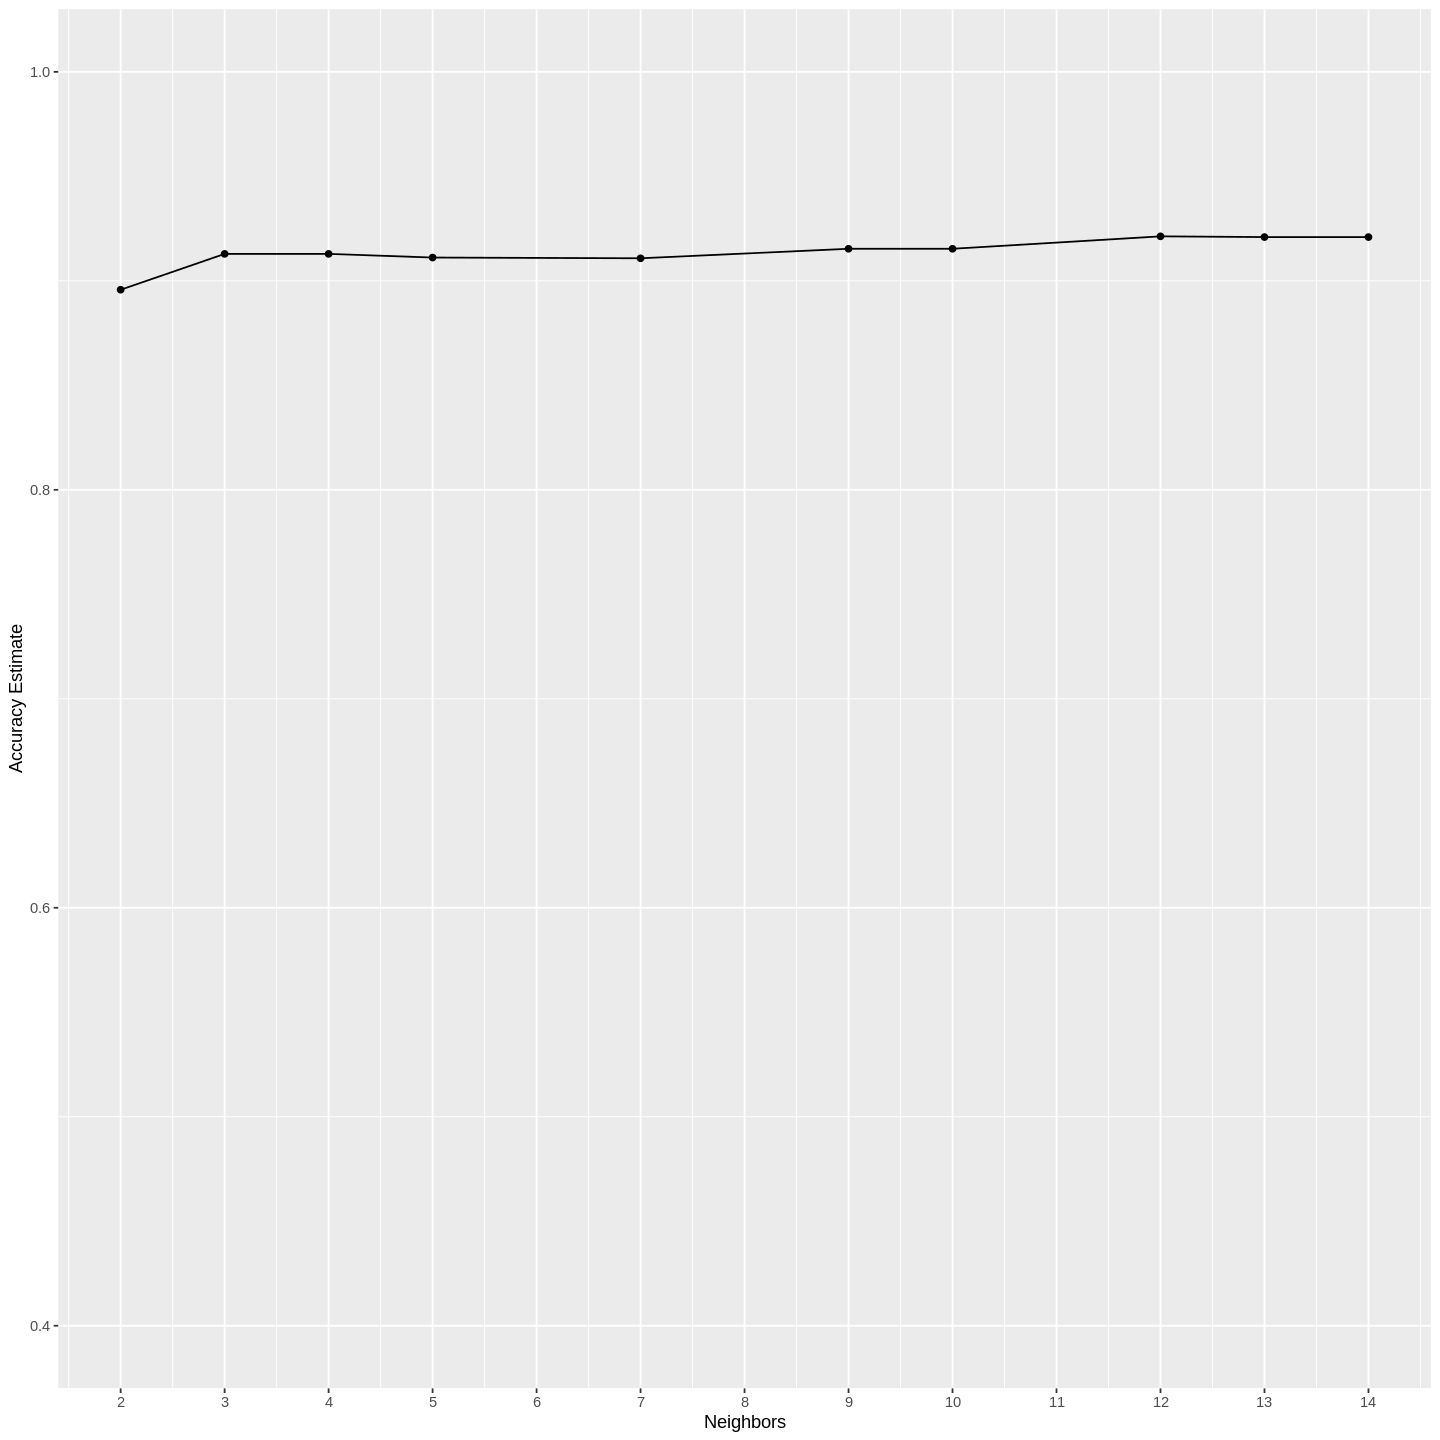

In [27]:
accuracies <- knn_results %>% 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

K = 12 seems to have the highest accuracy.

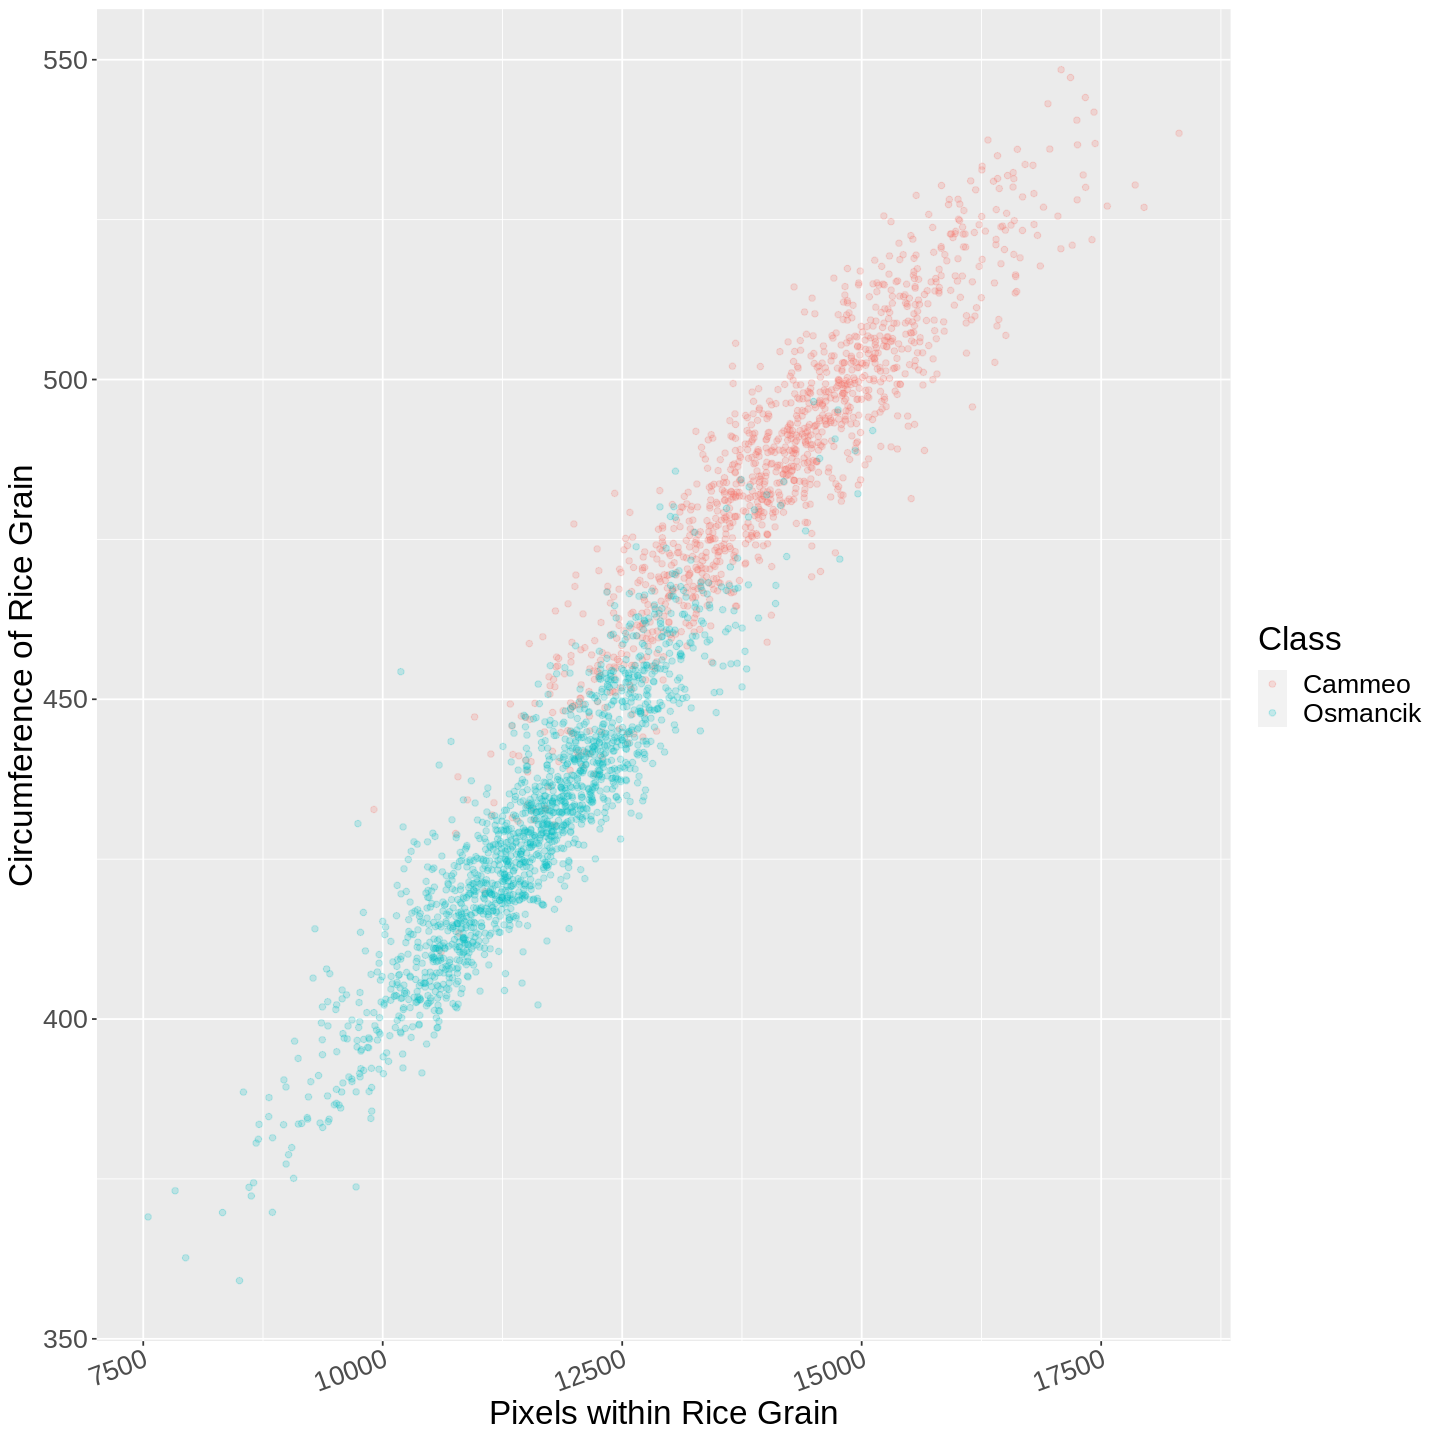

In [9]:
options(repr.plot.width = 12, repr.plot.height = 12)
rice_plot <- rice_train %>%
        ggplot(aes(x = AREA, y = PERIMETER, colour = CLASS)) + 
        geom_point(alpha = 0.2) +
        xlab("Pixels within Rice Grain") + 
        ylab("Circumference of Rice Grain") + 
        theme(text = element_text(size=20)) +
        labs(colour = "Class") +
        theme(axis.text.x = element_text(angle = 20, hjust = 1))
rice_plot